# NBA Assist Networks

Similar to tutorial about [WNBA Assist Networks](https://github.com/basketballrelativity/assist_networks/blob/master/wnba_assist_networks.ipynb), this tutorial dives into the NBA side and demonstrates how to build assist networks using data from [stats.nba.com](https://stats.nba.com).

The following explores the `PlayByPlay` and `Player` classes of the [py_ball](https://github.com/basketballrelativity/py_ball) package by exploring the `playbyplayv2` and `shotchartdetail` endpoints of the [stats.nba.com](https://stats.nba.com). The goal of this analysis is to follow the same methodology as used on the WNBA side to generate assist networks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import itertools

from PIL import Image
import time

from py_ball import playbyplay, player

HEADERS = {'Connection': 'keep-alive',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'x-nba-stats-origin': 'stats',
           'x-nba-stats-token': 'true',
           'Accept-Language': 'en-US,en;q=0.9',
           "X-NewRelic-ID": "VQECWF5UChAHUlNTBwgBVw==",
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6)' +\
                         ' AppleWebKit/537.36 (KHTML, like Gecko)' + \
                         ' Chrome/81.0.4044.129 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `PlayByPlay` class requires just one parameter:
- game_id: The unique identifier for the game of interest

The following pulls play-by-play data for a 2019 NBA Finals game between the Raptors and the Warriors.

In [2]:
game_id = '0021900115'
plays = playbyplay.PlayByPlay(headers=HEADERS,
                              endpoint='playbyplayv2',
                              game_id=game_id)

play_df = pd.DataFrame(plays.data['PlayByPlay'])
play_df.head(35)

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0021900115,2,12,0,1,10:41 PM,12:00,None,None,None,...,None,None,0,0,None,NaN,None,None,None,0
1,0021900115,4,10,0,1,10:41 PM,12:00,Jump Ball Zubac vs. Whiteside: Tip to Lillard,None,None,...,Trail Blazers,POR,5,203081,Damian Lillard,1.610613e+09,Portland,Trail Blazers,POR,1
2,0021900115,7,2,101,1,10:42 PM,11:46,None,None,MISS McCollum 14' Driving Floating Jump Shot,...,None,None,0,0,None,NaN,None,None,None,1
3,0021900115,8,4,0,1,10:42 PM,11:43,Leonard REBOUND (Off:0 Def:1),None,None,...,None,None,0,0,None,NaN,None,None,None,0
4,0021900115,9,2,78,1,10:42 PM,11:33,MISS Leonard 7' Floating Jump Shot,None,None,...,None,None,0,0,None,NaN,None,None,None,1
5,0021900115,10,4,0,1,10:42 PM,11:32,Zubac REBOUND (Off:1 Def:0),None,None,...,None,None,0,0,None,NaN,None,None,None,1
6,0021900115,69,2,97,1,10:42 PM,11:32,MISS Zubac 2' Tip Layup Shot,None,None,...,None,None,0,0,None,NaN,None,None,None,0
7,0021900115,70,4,0,1,10:42 PM,11:32,Zubac REBOUND (Off:2 Def:0),None,None,...,None,None,0,0,None,NaN,None,None,None,1
8,0021900115,11,1,58,1,10:42 PM,11:29,Zubac 5' Turnaround Hook Shot (2 PTS),None,None,...,None,None,0,0,None,NaN,None,None,None,1
9,0021900115,12,1,79,1,10:42 PM,11:17,None,None,Lillard 27' 3PT Pullup Jump Shot (3 PTS),...,None,None,0,0,None,NaN,None,None,None,1


By examining the above play, which includes an assisted basket, we see that the player credited with the assist is included in the play-by-play data through the PLAYER2 fields. We need to join this table to shot location data using the EVENTNUM field.

The `shotchartdetail` endpoint accepts a variety of parameters, but only a few are relevant for shot probability purposes:

- league_id: '00' for the NBA, '10' for the WNBA
- player_id: The unique identifier for the player (0 returns shot data for the whole game)
- game_id: The unique identifier for the game of interest
- season: YYYY-ZZ season year format (This only affects the league averages returned)
- season_type: One of 'Regular Season', 'Pre Season', 'Playoffs', 'All Star'

In [3]:
play_df.loc[2]['PLAYER1_TEAM_ID']

1610612757.0

In [4]:
league_id = '00' #NBA
player_id = '0' #All players
season = '2019-20'
season_type = 'Regular Season'

shots = player.Player(headers=HEADERS,
                      endpoint='shotchartdetail',
                      league_id=league_id,
                      player_id=player_id,
                      game_id=game_id,
                      season=season,
                      season_type=season_type)
shot_df = pd.DataFrame(shots.data['Shot_Chart_Detail'])
shot_df.head(15)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021900115,7,203468,CJ McCollum,1610612757,Portland Trail Blazers,1,11,46,...,Right Side(R),8-16 ft.,14,84,114,1,0,20191107,LAC,POR
1,Shot Chart Detail,0021900115,9,202695,Kawhi Leonard,1610612746,LA Clippers,1,11,33,...,Center(C),Less Than 8 ft.,7,-1,70,1,0,20191107,LAC,POR
2,Shot Chart Detail,0021900115,69,1627826,Ivica Zubac,1610612746,LA Clippers,1,11,32,...,Center(C),Less Than 8 ft.,1,2,18,1,0,20191107,LAC,POR
3,Shot Chart Detail,0021900115,11,1627826,Ivica Zubac,1610612746,LA Clippers,1,11,29,...,Center(C),Less Than 8 ft.,5,-32,42,1,1,20191107,LAC,POR
4,Shot Chart Detail,0021900115,12,203081,Damian Lillard,1610612757,Portland Trail Blazers,1,11,17,...,Center(C),24+ ft.,27,81,262,1,1,20191107,LAC,POR
5,Shot Chart Detail,0021900115,16,1627826,Ivica Zubac,1610612746,LA Clippers,1,10,52,...,Center(C),Less Than 8 ft.,3,-36,6,1,0,20191107,LAC,POR
6,Shot Chart Detail,0021900115,18,202335,Patrick Patterson,1610612746,LA Clippers,1,10,48,...,Center(C),Less Than 8 ft.,0,0,-6,1,0,20191107,LAC,POR
7,Shot Chart Detail,0021900115,20,203918,Rodney Hood,1610612757,Portland Trail Blazers,1,10,41,...,Right Side Center(RC),24+ ft.,24,153,197,1,0,20191107,LAC,POR
8,Shot Chart Detail,0021900115,22,201976,Patrick Beverley,1610612746,LA Clippers,1,10,29,...,Center(C),Less Than 8 ft.,1,-14,-3,1,0,20191107,LAC,POR
9,Shot Chart Detail,0021900115,24,202695,Kawhi Leonard,1610612746,LA Clippers,1,10,20,...,Center(C),Less Than 8 ft.,1,18,6,1,1,20191107,LAC,POR


In [5]:
assist_df = shot_df.merge(play_df[['EVENTNUM',
                                   'HOMEDESCRIPTION',
                                   'VISITORDESCRIPTION',
                                   'PLAYER2_ID',
                                   'PLAYER2_NAME']], left_on='GAME_EVENT_ID', right_on='EVENTNUM')

assist_df = assist_df[pd.notnull(assist_df['PLAYER2_NAME'])]

In [6]:
assist_df.head().T

,12,21,24,26,29
GRID_TYPE,Shot Chart Detail,Shot Chart Detail,Shot Chart Detail,Shot Chart Detail,Shot Chart Detail
GAME_ID,0021900115,0021900115,0021900115,0021900115,0021900115
GAME_EVENT_ID,30,48,60,66,81
PLAYER_ID,203918,202355,202335,202335,1627826
PLAYER_NAME,Rodney Hood,Hassan Whiteside,Patrick Patterson,Patrick Patterson,Ivica Zubac
TEAM_ID,1610612757,1610612757,1610612746,1610612746,1610612746
TEAM_NAME,Portland Trail Blazers,Portland Trail Blazers,LA Clippers,LA Clippers,LA Clippers
PERIOD,1,1,1,1,1
MINUTES_REMAINING,9,7,7,6,5
SECONDS_REMAINING,38,49,0,24,44


To create a network, we need to establish both nodes and edges. Each edge goes from a source node (assisting player) to a target node. The `network_data` function below also establishes coordinates for each node, along with the number of assists for each player. 

In [7]:
def network_data(pbp_df, team_id):
    """ network_dict creates nodes and edges
    for an assist network, along with information
    needed to plot the network

    @param pbp_df (DataFrame): DataFrame of play-by-play
        data with timeouts removed. Timeouts cause complications
        with getting players from the 'epid' field

    @param team_id (int): Unique team identifier

    Returns

        unique_players (list): List of player ID numbers
            corresponding to players on the team given

        edges (list): List of tuples in the form
            (assisting player ID, scoring player ID, number of assists)

        pos_dict (dict): Dictionary with keys of player ID numbers
            with (x, y) values corresponding to node coordinates

        weights (dict): Dictionary with keys of player ID numbers
            with assists as values
    """

    # First, let's identify all players on the team provided
    network = {}
    assist_df = pbp_df[pbp_df['TEAM_ID'] == team_id]
    unique_players = list(set(list(assist_df['PLAYER_ID']) + list(assist_df['PLAYER2_ID'])))
    unique_players = list(set([int(x) for x in unique_players]))

    # Next, we'll isolate the assists and loop through all unique assist
    # partners (assisting player, scorer)
    network['links'] = {}
    count = 0
    all_assists = zip(assist_df['PLAYER2_ID'], assist_df['PLAYER_ID'])
    all_assists = [(int(x), int(y)) for x, y in all_assists]
    unique_assists = list(set(all_assists))
    weights = {}
    for source, target in unique_assists:
        network['links'][count] = {}
        network['links'][count]['source'] = source
        network['links'][count]['target'] = target
        network['links'][count]['weight'] = sum([1 if x == (source, target) else 0 for x in all_assists])
        weights[(source, target)] = network['links'][count]['weight']
        count += 1

    links = len(network['links'])
    edges = [(network['links'][k]['source'],
              network['links'][k]['target'],
              network['links'][k]['weight']) for k in range(links)]

    # Finally, we'll get coordinates for all players in the assist
    # network around the unit circle
    angles = np.linspace(0, 360 - 360/float(len(unique_players)), len(unique_players))
    pos_dict = {}
    for angle, player in zip(angles, unique_players):
        pos_dict[player] = (np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle)))

    return unique_players, edges, pos_dict, weights

In [8]:
team_id = 1610612757
nodes, edges, positions, weights = network_data(assist_df, team_id)

Finally, we can write a function that uses `matplotlib` to visualize the assist network given the components created above. Let's first create a dictionary of names for display purposes.

In [9]:
team_df = assist_df[assist_df['TEAM_ID']==team_id]
team_name = team_df['TEAM_NAME'].iloc[0]
players = {}
unique_scorers = list(set(team_df['PLAYER_ID']))
for player in unique_scorers:
    if player not in players:
        players[player] = team_df[team_df['PLAYER_ID']==player]['PLAYER_NAME'].iloc[0]

unique_passers = list(set(team_df['PLAYER2_ID']))
for player in unique_passers:
    if player not in players:
        players[player] = team_df[team_df['PLAYER2_ID']==player]['PLAYER2_NAME'].iloc[0]

In [10]:
def plot_network(nodes, edges, positions, weights, players, team):
    """ plot_network plots the assist network given the
    data from the network_data function.

    @param nodes (list): List of player ID numbers
        corresponding to players on the team given

    @param edges (list): List of tuples in the form
        (assisting player ID, scoring player ID, number of assists)

    @param positions (dict): Dictionary with keys of player ID numbers
         with (x, y) values corresponding to node coordinates

    @param weights (dict): Dictionary with keys of player ID numbers
        with assists as values

    @param players (dict): Dict keyed by player IDs with their names
        as values

    @param team (str): Team name

    Returns

        fig (maplotlib.figure.Figure): Assist network visual
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')
    plt.title(team + ' Assist Network', fontsize=18)

    # First, let's plot each node, labeling each with player name and
    # number of assists. The number of assists also control the markersize
    # of the nodes. Because of this and varying name lengths, the name
    # position is perturbed to ensure proper formatting
    for pos in positions:
        assists = sum([weights[x] if x[0] == pos else 0 for x in weights])
        plt.plot(positions[pos][0], positions[pos][1], marker='o',
                 markersize=(1 + assists)*5, markeredgecolor='k', fillstyle='none')
        name = players[pos] + ' (' + str(int(assists)) + ')'
        if positions[pos][1] == 1:
            vertical_perturb = 0.003*(1 + assists)*5
        elif positions[pos][1] == -1:
            vertical_perturb = -0.005*(1 + assists)*5 - 0.05
        else:
            vertical_perturb = 0

        if positions[pos][0] < 0 and abs(positions[pos][1]) != 1:
            horiz_perturb = -0.0325*len(name) - 0.0025*(1 + assists)*5
        elif positions[pos][0] >= 0 and abs(positions[pos][1]) != 1:
            horiz_perturb = 0.0025*len(name) + 0.0025*(1 + assists)*5
        else:
            horiz_perturb = -0.0175*len(name)
            
        plt.text(positions[pos][0] + horiz_perturb, positions[pos][1] + vertical_perturb,
                 name, fontsize=12)

    # Next, the edges are plotted as arrows with the arrow going from 
    # the assisting player to the scoring player. The size of the arrow
    # is a function of the number of assists for that directed pair.
    # Also, the transparency is set to 0.5 to account for instances
    # when a pair of players have assists to each other.
    for edge in edges:
        node1 = edge[0]
        node2 = edge[1]
        assists = edge[2]

        start_x = positions[node1][0]
        start_y = positions[node1][1]

        delta_x = positions[node2][0] - start_x
        delta_y = positions[node2][1] - start_y

        plt.arrow(start_x, start_y, delta_x, delta_y, width=0.015*assists,
                  length_includes_head=True, alpha=0.5)

    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    axis.set_aspect(1.0)
    plt.axis('off')
    plt.close()

    return fig

In [11]:
network = plot_network(nodes, edges, positions, weights, players, team_name)

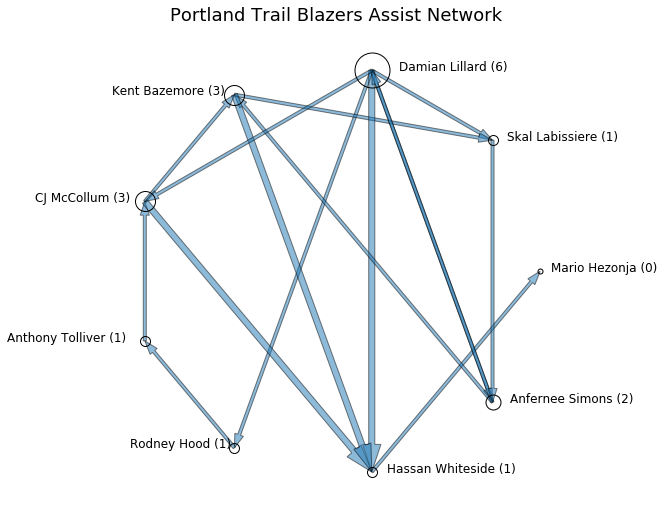

In [12]:
network

The assist network communicates a lot of information in a compact form:
    - Damian Lillard led the team with 6 assists and distributed them to five different teammates
    - Mario Hezonja scored an assisted basket but had no assists
    - Hassan Whiteside was the beneficiary of six assists
    - The greatest number of assists from one player to another is two
    
## Exploration

    - What else can you add or change about the above assist network to enhance the visualization?
    - What other events in basketball could be visualized by a network?